In [1]:
import json
import pandas as pd
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import networkx as nx
import numpy as np
from math import dist
import copy
import matplotlib.pyplot as plt
##### model
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_distances
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from gensim.models import Word2Vec
from sklearn.cluster import DBSCAN


import warnings
import collections
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import torch
from torch_geometric.utils.convert import from_networkx


%matplotlib inline



/Users/yanircohen/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# crate a list to add dataframes to
awsc_list = list()

# list of files
files_list = ['../Datasets/attack.json']

# Load event names
category_file = open("../Utils/event_category.json")
event_categories = json.load(category_file)
category_file.close()

encoder = OneHotEncoder(handle_unknown='ignore')
label_encoder = LabelEncoder()

In [3]:
for file in files_list:
    with open(file, 'r', encoding='utf-8') as f:
        data = json.loads(f.read())
        
        # Append the dataframes
        awsc_list.append(pd.DataFrame.from_records(data['Records']))

In [4]:
awsc = pd.concat(awsc_list).reset_index(drop=True)

In [5]:
awsc[(awsc['eventSource']=='cognito-idp.amazonaws.com')]

,userAgent,eventID,userIdentity,eventType,sourceIPAddress,eventName,eventSource,recipientAccountId,requestParameters,awsRegion,...,apiVersion,readOnly,resources,additionalEventData,sharedEventID,vpcEndpointId,managementEvent,eventCategory,sessionCredentialFromConsole,tlsDetails


In [6]:
users = pd.json_normalize(awsc['userIdentity']).merge(awsc[['eventTime','eventName','eventSource','awsRegion','errorCode']], left_index=True,right_index=True)

In [7]:
users['userName'] = users['userName'].fillna(users['arn']).fillna(users['invokedBy']) \
.fillna(users['invokedBy']).fillna(users['principalId']).fillna('accountId')

In [8]:
users = users[['eventTime','type','userName','eventName','eventSource','awsRegion','errorCode']]
users = users.rename(columns = {'eventTime':'timestamp','userName':'Identifier','eventSource':'TargetService','errorCode':'Error'})


In [9]:
users.head()


,timestamp,type,Identifier,eventName,TargetService,awsRegion,Error
0,2017-02-12T19:57:06Z,Root,arn:aws:iam::811596193553:root,ListBuckets,s3.amazonaws.com,us-east-1,NaN
1,2017-02-12T19:59:10Z,Root,arn:aws:iam::811596193553:root,GetAccountPasswordPolicy,iam.amazonaws.com,us-east-1,NoSuchEntityException
2,2017-02-12T19:59:10Z,Root,arn:aws:iam::811596193553:root,GetAccountSummary,iam.amazonaws.com,us-east-1,NaN
3,2017-02-12T19:59:10Z,Root,arn:aws:iam::811596193553:root,ListAccountAliases,iam.amazonaws.com,us-east-1,NaN
4,2017-02-12T19:59:10Z,Root,arn:aws:iam::811596193553:root,ListMFADevices,iam.amazonaws.com,us-east-1,NaN


In [10]:
users['timestamp'] = pd.to_datetime(users['timestamp']).map(pd.Timestamp.timestamp).map(int)
users = users.sort_values('timestamp',ascending=True,ignore_index=True)

In [11]:
users['Identifier'] = users['Identifier'].apply(lambda x : x if (len(x.split(":"))!=2) else x.split(":")[1])
users.nunique()

timestamp        58649
type                 5
Identifier          27
eventName          383
TargetService       49
awsRegion           15
Error               60
dtype: int64

In [12]:
users['identity-target'] = "source-"+users['Identifier'] + "|" + "target-"+ users['TargetService']

In [13]:
users.head()

,timestamp,type,Identifier,eventName,TargetService,awsRegion,Error,identity-target
0,1486929426,Root,arn:aws:iam::811596193553:root,ListBuckets,s3.amazonaws.com,us-east-1,NaN,source-arn:aws:iam::811596193553:root|target-s...
1,1486929550,Root,arn:aws:iam::811596193553:root,GetAccountPasswordPolicy,iam.amazonaws.com,us-east-1,NoSuchEntityException,source-arn:aws:iam::811596193553:root|target-i...
2,1486929550,Root,arn:aws:iam::811596193553:root,GetAccountSummary,iam.amazonaws.com,us-east-1,NaN,source-arn:aws:iam::811596193553:root|target-i...
3,1486929550,Root,arn:aws:iam::811596193553:root,ListAccountAliases,iam.amazonaws.com,us-east-1,NaN,source-arn:aws:iam::811596193553:root|target-i...
4,1486929550,Root,arn:aws:iam::811596193553:root,ListMFADevices,iam.amazonaws.com,us-east-1,NaN,source-arn:aws:iam::811596193553:root|target-i...


In [14]:
users['Identifier'] = users['Identifier'].apply(lambda x : f"source-{x}")
users['TargetService'] = users['TargetService'].apply(lambda x : f"target-{x}")

In [15]:
def get_time_df(start,end,minutes,df,col='timestamp'):
    minutes = minutes * 60
    df_list = []
    start_time = start
    while start < end:
        cur_df = df[(df[col] >= start_time) & (df[col] < start+minutes)]
        if len(cur_df):
            df_list.append(df[(df[col] >= start_time) & (df[col] < start+minutes)])
        start+=minutes
    return df_list

In [16]:
df_list = get_time_df(users['timestamp'].iloc[0],users['timestamp'].iloc[-1],60*60*24,users)

In [17]:
len(df_list)

38

# Create the graph

In [18]:
nodes = ['Identifier','TargetService']
edges = ['identity-target']


In [19]:
def add_nodes(g,df,col,x,jump=10):
    y = 10
    unique_nodes = df[col].unique()
    for i in unique_nodes:
        if i!= None:
            g.add_node(f'{i}',pos=(x,y))
            y+=jump
#     for i in range(len(unique_nodes)-1):
#         g.add_edge(unique_nodes[i],unique_nodes[i+1])

def add_edges(g,df,col):
    edges = df[col].value_counts()
    for node,value in edges.items():
        start_node,end_node = node.split('|')
        if "None" not in start_node and "None" not in end_node:
            g.add_edge(start_node, end_node, weight=1/value)

In [20]:
def generate_graph(G,df_nodes,df_edges):  
    x = 10
#     nodes_li = []
    for node in nodes:
        add_nodes(G,df_nodes,node,x,100)
        x+=1
#         nodes_li.append(df_nodes[node].unique())
#     for i in range(len(nodes_li)-1):
#         for node1 in nodes_li[i]:
#             for node2 in nodes_li[i+1]:
#                 G.add_edge(node1,node2,weight=0)
    for edge in edges:
        add_edges(G,df_edges,edge)

In [21]:
G = nx.Graph()

In [22]:
generate_graph(G,users,users)

In [23]:
def generate_graphs(df,df_list):
    li = []
    for data in df_list:
        G = nx.Graph()
        generate_graph(G,df,data)
        li.append(G)
    return li

In [24]:
graphs = generate_graphs(users,df_list)

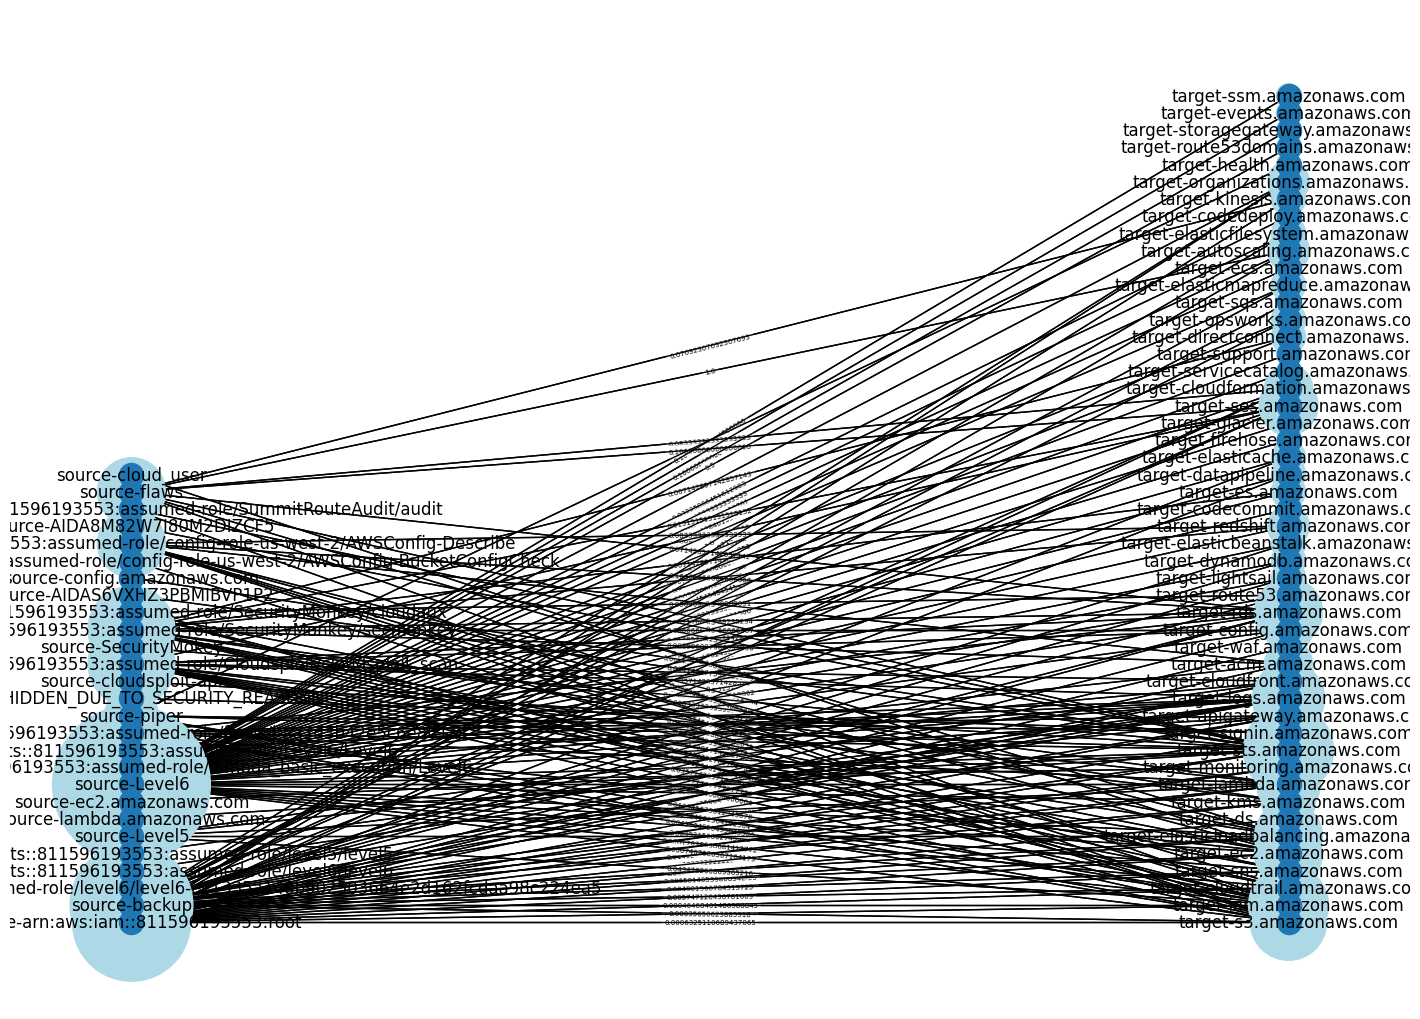

In [25]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10
pos=nx.get_node_attributes(G,'pos')
# pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))
d = dict(G.degree)
nx.draw(G, pos, node_color='lightblue', 
        with_labels=True, 
        nodelist=d, 
        node_size=[d[k]*300 for k in d])
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_size=5)
import matplotlib.pyplot as plt
plt.savefig(f'plotgraph.png', dpi=300, bbox_inches='tight')


pos=nx.get_node_attributes(G,'pos')
nx.draw(G,pos)
plt.show()

In [26]:
# from sklearn.manifold import SpectralEmbedding
# embedding = SpectralEmbedding(n_components=74)
# X = embedding.fit_transform(df)
walk_length = 20  # maximum length of a random walk to use throughout this notebook

In [27]:
def gen_stellar(graphs):
    stellar_list = []
    for G in graphs:
        G = StellarGraph.from_networkx(G)
        rw = BiasedRandomWalk(G)
        stellar_list.append((G,rw))
    return stellar_list

In [28]:
def weighted_walks_graphs(SL):
    WW = []
    for G,rw in SL:
        weighted_walks = rw.run(
          nodes=G.nodes(),  # root nodes
          length=walk_length,  # maximum length of a random walk
          n=10,  # number of random walks per root node
          p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
          q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
          weighted=True,  # for weighted random walks
          seed=42,  # random seed fixed for reproducibility
        )
        WW.append(weighted_walks)
    return WW

In [29]:
def weighted_models(WW):
    w2v_models = []
    for weighted_walks in WW:
        weighted_model = Word2Vec(
          weighted_walks, vector_size=128, window=5, min_count=0, sg=1, workers=1,
        )
        w2v_models.append(weighted_model)
    return w2v_models

In [30]:
def node_embedding(weighted_model_list):
    embedding = []
    for weighted_model in weighted_model_list:
        node_ids = weighted_model.wv.index_to_key  # list of node IDs
        weighted_node_embeddings = (
          weighted_model.wv.vectors
        ) 
        embedding.append((node_ids,weighted_node_embeddings))
    return embedding

In [31]:
def d2_graphs(embedding):
    embedding2d_annotation = []
    for node_ids,weighted_node_embeddings in embedding:
        tsne = TSNE(n_components=2, random_state=42)
        weighted_node_embeddings_2d = tsne.fit_transform(weighted_node_embeddings)
        embedding2d_annotation.append((node_ids,weighted_node_embeddings_2d))
    return embedding2d_annotation

In [32]:
SL = gen_stellar([G])
WW = weighted_walks_graphs(SL)
weighted_model_list = weighted_models(WW)
embedding = node_embedding(weighted_model_list)
d2_graphs_list = d2_graphs(embedding)
X = d2_graphs_list[0][1]

In [33]:
df_from_graphs = []
for graph in graphs:
    df_from_graphs.append(nx.to_pandas_adjacency(graph, dtype=float))

In [34]:
distance_df = pd.DataFrame(0, index=embedding[0][0], columns=embedding[0][0])

In [35]:
d2_graphs_list[0][0].index('source-cloud_user')

72

In [36]:
d2_graphs_list[0][0].index('source-arn:aws:sts::811596193553:assumed-role/Cloudsploit/cloudsploit_scan')

24

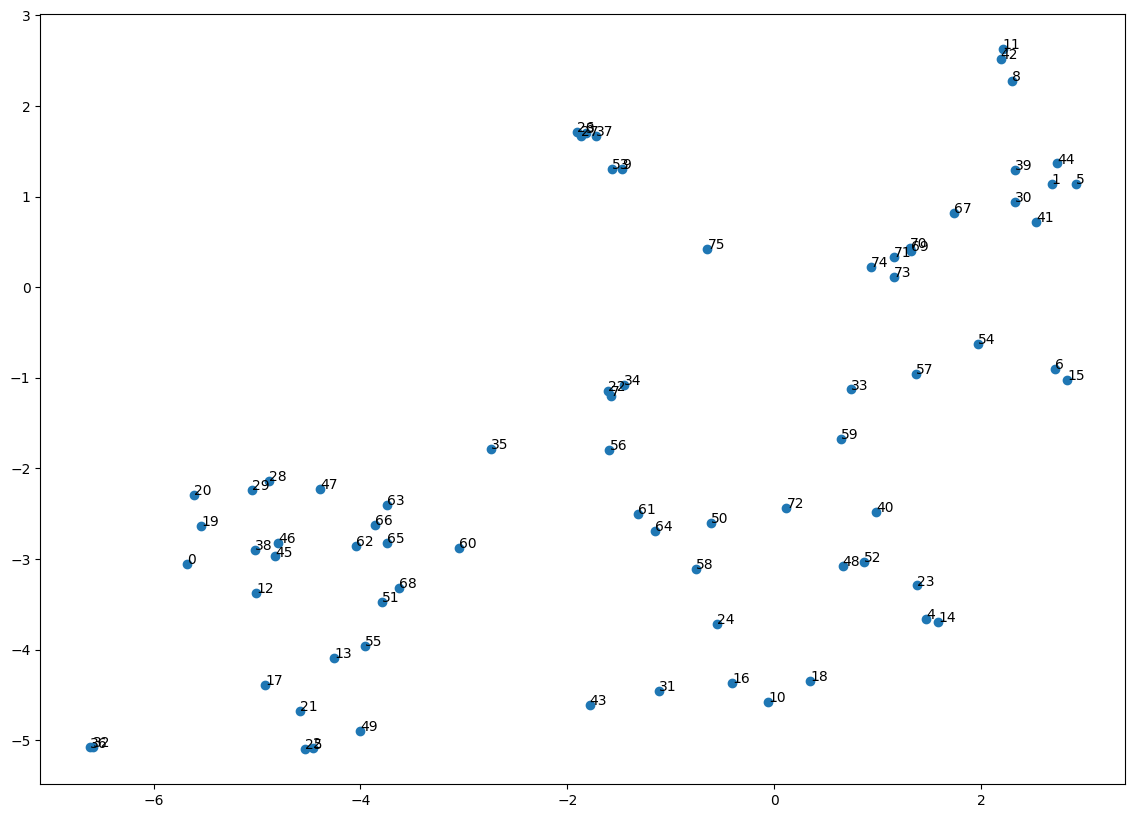

In [37]:
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1])

for i, txt in enumerate(X):
    ax.annotate(i, (txt[0], txt[1]))

In [38]:
X = embedding[0][1]

In [39]:
X

array([[ 0.19736631, -0.09463321,  0.36474708, ...,  0.1334825 ,
         0.07910514,  0.28406224],
       [-0.174879  ,  0.07496563,  0.6344106 , ..., -0.53089225,
        -0.18555684,  0.03604595],
       [ 0.01888817, -0.01278508,  0.0230546 , ...,  0.11658709,
         0.25562012,  0.22726066],
       ...,
       [-0.06517249,  0.01850152,  0.3002121 , ..., -0.2473034 ,
        -0.07310431,  0.03250787],
       [-0.05662334,  0.01238401,  0.2958993 , ..., -0.21648428,
        -0.08111009,  0.02940189],
       [-0.07741848,  0.05364524,  0.09691776, ..., -0.26744398,
        -0.03792956,  0.12509133]], dtype=float32)

In [40]:
from sklearn.neighbors import NearestNeighbors
a = 1
for df_graph in df_from_graphs:
#     a+=1
    target_cols = [col for col in df_graph.columns if 'target' in col]
    for col in target_cols:
        index_di = {}
        index_to_pd_index = {}
        nodes = df_graph[col].loc[df_graph[col]>0]
        for i,other in enumerate(nodes.items()):
            ind,_=other
            pd_index = d2_graphs_list[0][0].index(ind)
            index_di[pd_index] = ind
            index_to_pd_index[i] = ind
        if len(index_di) > 1:
            x = X[list(index_di.keys())]
            nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(x)
            distances, indices = nbrs.kneighbors(x)
            for i,other in enumerate(index_di.items()):
                key,value = other
                nearest_neighbor = indices[i][1]
                nearest_neighbor_ind = index_to_pd_index[nearest_neighbor]
                if distance_df.loc[value,nearest_neighbor_ind] <  distances[i][1]*a:
                    distance_df.loc[value,nearest_neighbor_ind] = distances[i][1]*a

In [41]:
df_from_graphs[0]

,source-arn:aws:iam::811596193553:root,source-backup,source-arn:aws:sts::811596193553:assumed-role/level6/level6-ec1335a148b902503664e2d162fcdaa98c224ea5,source-arn:aws:sts::811596193553:assumed-role/level6/level6,source-arn:aws:sts::811596193553:assumed-role/level5/level5,source-Level5,source-lambda.amazonaws.com,source-ec2.amazonaws.com,source-Level6,source-arn:aws:sts::811596193553:assumed-role/lambda_basic_execution/Level6,...,target-autoscaling.amazonaws.com,target-elasticfilesystem.amazonaws.com,target-codedeploy.amazonaws.com,target-kinesis.amazonaws.com,target-organizations.amazonaws.com,target-health.amazonaws.com,target-route53domains.amazonaws.com,target-storagegateway.amazonaws.com,target-events.amazonaws.com,target-ssm.amazonaws.com
source-arn:aws:iam::811596193553:root,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.017857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
source-backup,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
source-arn:aws:sts::811596193553:assumed-role/level6/level6-ec1335a148b902503664e2d162fcdaa98c224ea5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
source-arn:aws:sts::811596193553:assumed-role/level6/level6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
source-arn:aws:sts::811596193553:assumed-role/level5/level5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
target-health.amazonaws.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
target-route53domains.amazonaws.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
target-storagegateway.amazonaws.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
target-events.amazonaws.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
cols = [c for c in distance_df.columns if 'target' not in c]

distance_df = distance_df[cols].drop(distance_df.columns.difference(cols))

In [43]:
result = nx.from_pandas_adjacency(distance_df)

In [53]:
pos_di = {}
for i in range(len(d2_graphs_list[0][0])):
    if 'source' in d2_graphs_list[0][0][i]:
        pos_di[d2_graphs_list[0][0][i]] = d2_graphs_list[0][1][i]

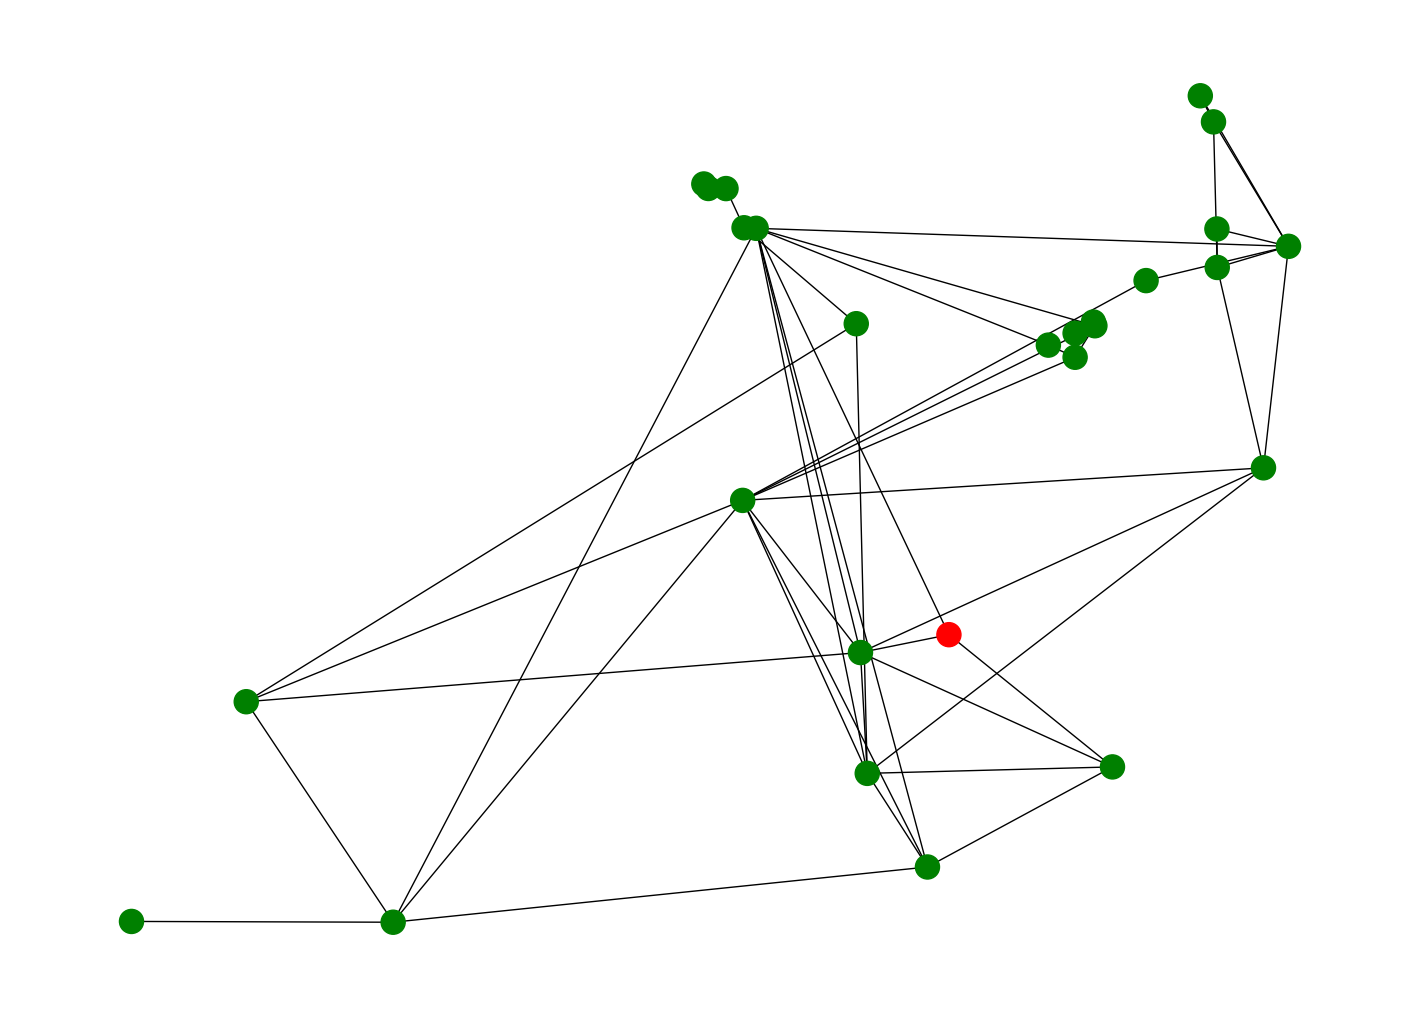

In [54]:

color_map = ['red' if node == 'source-cloud_user' else 'green' for node in result]        
# pos=nx.spring_layout(result) # pos = nx.nx_agraph.graphviz_layout(G)
nx.draw(result,pos=pos_di,node_color=color_map)
# labels = nx.get_edge_attributes(result,'weight')
# nx.draw_networkx_edge_labels(result,pos=pos)
plt.savefig("res.png")

In [45]:
distance_df.loc['source-cloud_user']

source-Level6                                                                                           0.000000
source-backup                                                                                           0.000000
source-arn:aws:sts::811596193553:assumed-role/config-role-us-west-2/AWSConfig-Describe                  0.000000
source-piper                                                                                            0.000000
source-flaws                                                                                            0.000000
source-arn:aws:iam::811596193553:root                                                                   0.000000
source-arn:aws:sts::811596193553:assumed-role/SummitRouteAudit/audit                                    0.000000
source-arn:aws:sts::811596193553:assumed-role/flaws/i-aa2d3b42e5c6e801a                                 0.000000
source-Level5                                                                                   

In [46]:
distance_df['source-cloud_user']

source-Level6                                                                                           0.000000
source-backup                                                                                           0.000000
source-arn:aws:sts::811596193553:assumed-role/config-role-us-west-2/AWSConfig-Describe                  1.719083
source-piper                                                                                            0.000000
source-flaws                                                                                            0.000000
source-arn:aws:iam::811596193553:root                                                                   0.000000
source-arn:aws:sts::811596193553:assumed-role/SummitRouteAudit/audit                                    0.000000
source-arn:aws:sts::811596193553:assumed-role/flaws/i-aa2d3b42e5c6e801a                                 1.740173
source-Level5                                                                                   